In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from src.sky_cloud_segmentation_dl.dataset import get_dataloaders
from src.utils.random_utils import set_seed

GENERATED_PATH = '../generated/'

BATCH_SIZE = 1
SEPARATE_CLOUDS = False

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

SEED = 14

set_seed(SEED)

In [3]:
train_loader, val_loader = get_dataloaders(BATCH_SIZE, separate_clouds=SEPARATE_CLOUDS)

✅ Created SeededDataLoader with seed 42.
✅ Loaded data.
➡️ Number of train images: 51
➡️ Number of val images: 13


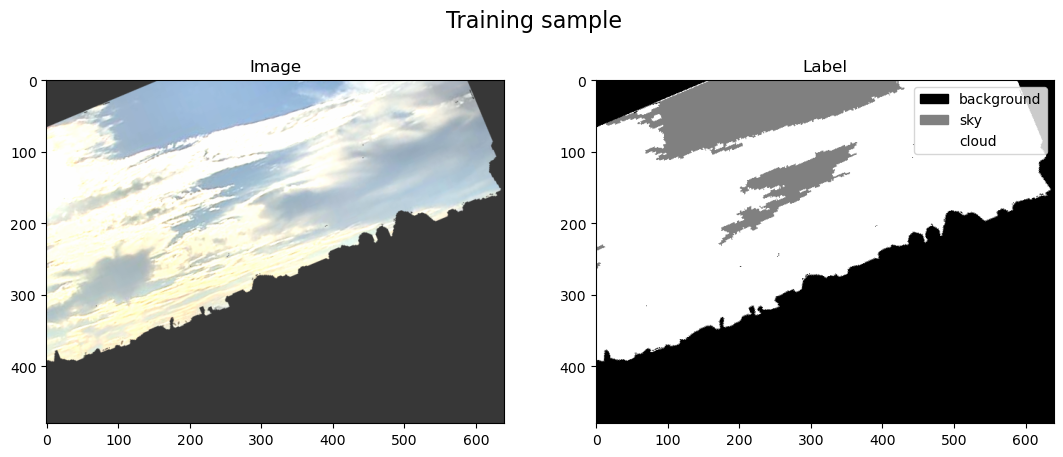

💾 Plot saved at ../generated/sky_cloud_segmentation//cloud_segmentation_dataset_training_sample.png


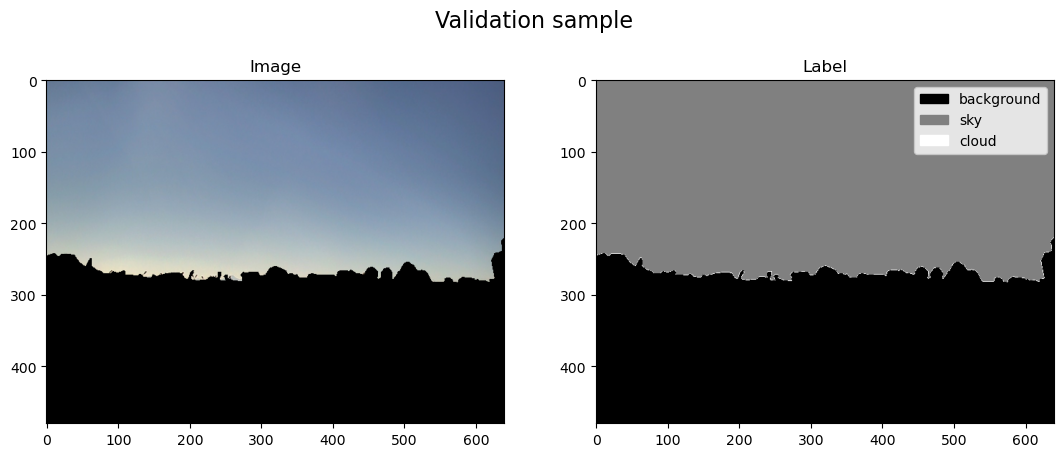

💾 Plot saved at ../generated/sky_cloud_segmentation//cloud_segmentation_dataset_validation_sample.png


In [4]:
def show_first_sample(loader, title):
    # Get data
    iterator = iter(loader)
    image, label = next(iterator)
    image = image.squeeze(0).permute(1, 2, 0)
    label = label.squeeze(0).permute(1, 2, 0)

    # Normalize image
    image = image.numpy()
    image = IMAGENET_STD * image + IMAGENET_MEAN
    image = np.clip(image, 0, 1)

    # Flatten label
    label = label.numpy().argmax(axis=-1)

    # PLot 
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(label, cmap='gray', vmin=0, vmax=2)
    # Create custom patches for the legend
    classes = ['background', 'sky', 'cloud']
    class_colors = [plt.cm.gray(i / 255.0) for i in [0, 128, 255]]  # Normalize and get colors
    patches = [mpatches.Patch(color=class_colors[i], label=classes[i]) for i in range(len(classes))]

    # Add the legend to the second subplot
    ax[1].legend(handles=patches, loc='upper right')
    ax[1].set_title('Label')
    fig.suptitle(title, fontsize=16)
    plt.show()

    # Save plot
    generated_sky_cloud_segmentation_path = f'{GENERATED_PATH}sky_cloud_segmentation/'
    if not os.path.exists(generated_sky_cloud_segmentation_path):
        os.makedirs(generated_sky_cloud_segmentation_path)
    plot_path = f'{generated_sky_cloud_segmentation_path}/cloud_segmentation_dataset_{title.lower().replace(" ", "_")}.png'
    fig.savefig(plot_path)
    print(f'💾 Plot saved at {plot_path}')

show_first_sample(train_loader, 'Training sample')
show_first_sample(val_loader, 'Validation sample')